In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
import re

from jupyters.visu_utils import load_sts_merged_mteb
from visu_utils import TASK_LIST_CLASSIFICATION, make_results_tables_per_group_size, load_classification_merged_mteb, \
    load_clustering_merged_mteb


from autorank import autorank, plot_stats, create_report, latex_table

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)

%reload_ext autoreload
%autoreload 2

models = ['paraphrase-multilingual', 'msmarco', 'ALL', "m-v1.5", "unsup-sim"]
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{lmodern}')


In [2]:

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)


CSV_PATH = "global_table.csv"



df = pd.read_csv(CSV_PATH)



In [6]:


def make_rank_heatmap_with_mask(df_rank, ax, common_kwargs):
    # make a mask that is True for the best value per line
    
    mask = np.zeros(df_rank.shape, dtype=bool)
    
    for i in range(df_rank.shape[0]):
        mask[i, df_rank.iloc[i].argmin()] = True
    

    annot_underline = np.empty(df_rank.shape, dtype=object)
    for i in range(df_rank.shape[0]):
        for j in range(df_rank.shape[1]):
            annot_underline[i, j] = f"\\textbf{{\\underline{{{df_rank.iloc[i, j]:.0f}}}}}"

    annot = np.empty(df_rank.shape, dtype=object)
    for i in range(df_rank.shape[0]):
        for j in range(df_rank.shape[1]):
            annot[i, j] = f"{df_rank.iloc[i, j]:.0f}"

    # format the sns with underline 
    sns.heatmap(df_rank, ax=ax, cmap='flare', annot_kws={"size": 12}, annot=annot_underline, fmt="", cbar=False, 
                mask=~mask,vmin=1, vmax=12, **common_kwargs)

    # format the sns with the values
    sns.heatmap(df_rank, ax=ax, cmap='flare', annot_kws={"size": 12}, annot=annot, fmt="", cbar=False, mask=mask, vmin=1, vmax=12,
                **common_kwargs)



In [8]:



# export csv




\textbf{Student-xs - NLL}
GIST-all-MiniLM-L6-v2
\textbf{Student-xs - MSE}
Ivysaur
gte-tiny
slx-v0.1
snowflake-arctic-embed-xs
all-MiniLM-L6-v2
multi-qa-MiniLM-L6-cos-v1
\textbf{Student-xs - NLL}
GIST-all-MiniLM-L6-v2
\textbf{Student-xs - MSE}
Ivysaur
gte-tiny
slx-v0.1
snowflake-arctic-embed-xs
all-MiniLM-L6-v2
multi-qa-MiniLM-L6-cos-v1


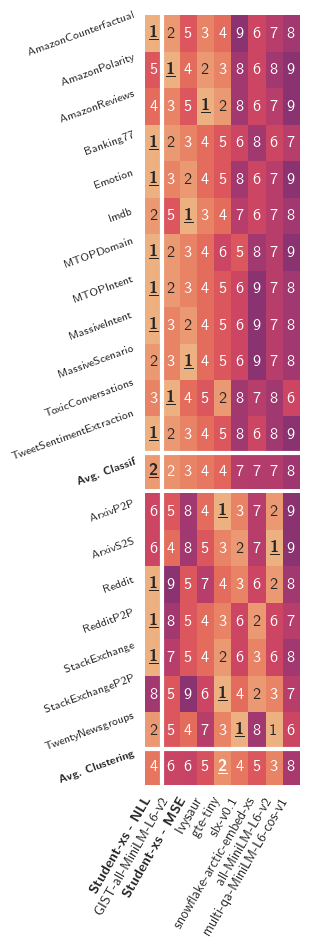

In [39]:




parameters = {'xs': {'ylabel': 8, 'task_div' : 2, 'model_div' : 4, 'xlabel': 10,},
              'm' : {'ylabel': 16, 'task_div' : 2, 'model_div' : 5, 'xlabel': 16},
               's' : {'ylabel': 16, 'task_div' : 2, 'model_div' : 5, 'xlabel': 16},
              }

for size, group in df.groupby(['Size Group']):
    if size[0] == 'l':
        continue
    if size[0] != "xs":
        continue
    n_types = group['Type'].nunique()
    
    n_models = group['Model'].nunique()
    n_tasks = group['Task'].nunique()
    
    ratios = [g['Task'].nunique() for _, g in group.groupby('Type')]
    
    # get model names ordered by Avg. Classif
    
    common_models = set(group['Model'].unique())
    
    for k, (type, group_type) in enumerate(group.groupby('Type')):
        common_models = common_models.intersection(group_type['Model'].unique())
        
    # keep only models that are in common
    common_models = [c for c in common_models if "rubert" not in c]
    group = group[group['Model'].isin(common_models)]
    

    model_order = group[(group['Task'] == '\\textbf{Avg. Classif}')].sort_values('Rank', ascending=True)['Model'].tolist()[:12]

    fig, ax = plt.subplots(n_types, 1, figsize=(n_models // parameters[size[0]]['model_div'], n_tasks // parameters[size[0]]['task_div']), squeeze=False, sharex=True, gridspec_kw={"height_ratios":ratios})
    ax = ax.flatten()
    for k, (type, group_type) in enumerate(group.groupby('Type')):
        df_rank = group_type.pivot_table(index='Model', columns='Task', values='Rank')
        df_rank = df_rank.dropna()
        
        # Put Avg Classif and Avg Clustering at the end
        df_rank = df_rank[
            [col for col in df_rank.columns if not col.startswith('Avg')] + [col for col in df_rank.columns if
                                                                             col.startswith('Avg')]]
        
        ax[k].axhline(y=len(df_rank.columns) -1, lw=3, color='white')
        
        # take intersection of models
        remaining_models = df_rank.index.tolist()
        
        
        try:
            df_rank = df_rank.loc[model_order]
        except KeyError as e:
            print(f"Error for {size} {type}")
            print(e)
            continue

        make_rank_heatmap_with_mask(df_rank.T, ax[k], common_kwargs={})
        
        for kk, c in enumerate(df_rank.T.columns):
            print(c)
            if "- NLL" in c:
                if kk != 0:
                    ax[k].axvline(x=kk, lw=3, color='white')
                ax[k].axvline(x=kk+1, lw=3, color='white')

        # remove axes labels
        ax[k].set_ylabel('')
        ax[k].set_xlabel('')

        ax[k].set_yticklabels(ax[k].get_yticklabels(), fontsize=parameters[size[0]]['ylabel'], rotation=20)
    
    ax[-1].set_xticklabels(ax[-1].get_xticklabels(), rotation=60, ha='right', fontsize=parameters[size[0]]['xlabel'])
        
        
    fig.subplots_adjust(wspace=0, hspace=0.01)
    # fig.tight_layout()
    fig.savefig(EXPORT_PATH_FIG / f"global_ranking_{size[0]}.pdf", bbox_inches='tight')


